# Exploring the Relationship Between Movie Genres and Gross Domestic Revenue

For our first business insight, we will be researching and exploring how genre affects domestic revenue. This is relevant as very costly resources are allocated to creating movies and it is important to understand what genres perform the best prior to making a decision as to what kind of movies Computing Vision will make. Let's start by taking a look at our movie data.

<img src="https://i0.wp.com/news.northeastern.edu/wp-content/uploads/2022/05/movie_theater_1400.jpg?w=1400&ssl=1" width=500>

Image Source: https://news.northeastern.edu/2022/05/26/movie-theater-hearing-damage/

By Alivia and Vaia

In [ ]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from math import sqrt
%matplotlib inline

In [3]:
# connect to sqlite database to import data and view genres of movies
conn = sqlite3.connect("../../zippedData/im.db")
imbd = pd.read_sql('''
SELECT *
FROM movie_basics

''', conn)

In [4]:
# preview data
imbd.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [5]:
# view data cleanliness and null values
imbd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


In [1]:
# import csv with domestic revenue and preview data
revenue_df = pd.read_csv("../../zippedData/tn.movie_budgets.csv.gz")
revenue_df.head()

NameError: name 'pd' is not defined

In [7]:
# rename column with movie title to prepare for pandas join
revenue_df.rename(columns={'movie': 'primary_title'}, inplace=True)
revenue_df.head()

,id,release_date,primary_title,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [8]:
# create new dataframe including genre, domestic revenue, and  movie title
movies1 = pd.merge(imbd, revenue_df, on ='primary_title')
movies1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3815 entries, 0 to 3814
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_id           3815 non-null   object 
 1   primary_title      3815 non-null   object 
 2   original_title     3814 non-null   object 
 3   start_year         3815 non-null   int64  
 4   runtime_minutes    3328 non-null   float64
 5   genres             3743 non-null   object 
 6   id                 3815 non-null   int64  
 7   release_date       3815 non-null   object 
 8   production_budget  3815 non-null   object 
 9   domestic_gross     3815 non-null   object 
 10  worldwide_gross    3815 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 357.7+ KB


In [9]:
# drop rows with genre value as null
movies = movies1.dropna(subset= ['genres'])
movies.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,id,release_date,production_budget,domestic_gross,worldwide_gross
0,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",26,"Dec 31, 2012","$45,000,000",$0,"$73,706"
1,tt0293429,Mortal Kombat,Mortal Kombat,2021,NaN,"Action,Adventure,Fantasy",10,"Aug 18, 1995","$20,000,000","$70,433,227","$122,133,227"
3,tt3844362,The Overnight,The Overnight,2015,79.0,"Comedy,Mystery",21,"Jun 19, 2015","$200,000","$1,109,808","$1,165,996"
4,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",17,"Mar 22, 2013","$25,000,000","$720,828","$9,313,302"
5,tt2404548,On the Road,On the Road,2011,90.0,Drama,17,"Mar 22, 2013","$25,000,000","$720,828","$9,313,302"


In [10]:
# create column which contains just one genre instead of a list of genres
movies['main_genre'] = movies["genres"].str.split(',')
movies_df = movies.explode('main_genre')

<ipython-input-10-eb6c512f8464>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['main_genre'] = movies["genres"].str.split(',')


In [11]:
# dropping duplicates 
movies_df = movies_df.drop_duplicates(subset= ['movie_id'])

In [12]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3539 entries, 0 to 3814
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie_id           3539 non-null   object 
 1   primary_title      3539 non-null   object 
 2   original_title     3539 non-null   object 
 3   start_year         3539 non-null   int64  
 4   runtime_minutes    3133 non-null   float64
 5   genres             3539 non-null   object 
 6   id                 3539 non-null   int64  
 7   release_date       3539 non-null   object 
 8   production_budget  3539 non-null   object 
 9   domestic_gross     3539 non-null   object 
 10  worldwide_gross    3539 non-null   object 
 11  main_genre         3539 non-null   object 
dtypes: float64(1), int64(2), object(9)
memory usage: 359.4+ KB


In [13]:
movies_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,id,release_date,production_budget,domestic_gross,worldwide_gross,main_genre
0,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",26,"Dec 31, 2012","$45,000,000",$0,"$73,706",Action
1,tt0293429,Mortal Kombat,Mortal Kombat,2021,NaN,"Action,Adventure,Fantasy",10,"Aug 18, 1995","$20,000,000","$70,433,227","$122,133,227",Action
3,tt3844362,The Overnight,The Overnight,2015,79.0,"Comedy,Mystery",21,"Jun 19, 2015","$200,000","$1,109,808","$1,165,996",Comedy
4,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",17,"Mar 22, 2013","$25,000,000","$720,828","$9,313,302",Adventure
5,tt2404548,On the Road,On the Road,2011,90.0,Drama,17,"Mar 22, 2013","$25,000,000","$720,828","$9,313,302",Drama
...,...,...,...,...,...,...,...,...,...,...,...,...
3810,tt9678962,Fuel,Fuel,2018,NaN,"Documentary,Sport",35,"Nov 14, 2008","$2,500,000","$174,255","$174,255",Documentary
3811,tt9729206,Diner,Diner,2019,NaN,Crime,11,"Apr 2, 1982","$5,000,000","$12,592,907","$12,592,907",Crime
3812,tt9805168,Traitor,Traitor,2015,110.0,"Action,Drama,Romance",25,"Aug 27, 2008","$22,000,000","$23,530,831","$27,882,226",Action
3813,tt9844102,Ray,Ray,2018,111.0,Crime,8,"Oct 29, 2004","$40,000,000","$75,305,995","$124,823,094",Crime


In [14]:
# make domestic gross into integer without dollar sign
def clean_dollar(df, column):
    df[column] = df[column].str.strip('$')
    df[column] = df[column].str.replace(',','')
    df[column] = df[column].astype(int)
    return df[column]

clean_dollar(movies_df,'domestic_gross')

0              0
1       70433227
3        1109808
4         720828
5         720828
          ...   
3810      174255
3811    12592907
3812    23530831
3813    75305995
3814           0
Name: domestic_gross, Length: 3539, dtype: int32

In [49]:
# sort data frame to ensure that the visualization is in order
sorted_movies_df = movies_df.sort_values(['main_genre','domestic_gross'], ascending=True)
sorted_movies_df.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,id,release_date,production_budget,domestic_gross,worldwide_gross,main_genre
0,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",26,"Dec 31, 2012","$45,000,000",0,"$73,706",Action
108,tt4706780,Red Dog,Pyos Ryzhiy,2016,99.0,"Action,Drama,History",67,"Dec 31, 2011","$9,100,000",0,"$20,927,794",Action
110,tt8035272,Red Dog,Red Dog,2018,NaN,"Action,Drama,History",67,"Dec 31, 2011","$9,100,000",0,"$20,927,794",Action
164,tt0923653,The Dead Undead,The Dead Undead,2010,89.0,"Action,Horror,Sci-Fi",7,"Dec 31, 2010","$1,100,000",0,$0,Action
369,tt10329842,Geroy,Geroy,2019,NaN,Action,65,"Dec 31, 2015","$7,000,000",0,"$1,545,121",Action


In [63]:
total_action = sorted_movies_df[(sorted_movies_df['main_genre'] == 'Horror')]
max(total_action['domestic_gross'])

760507625

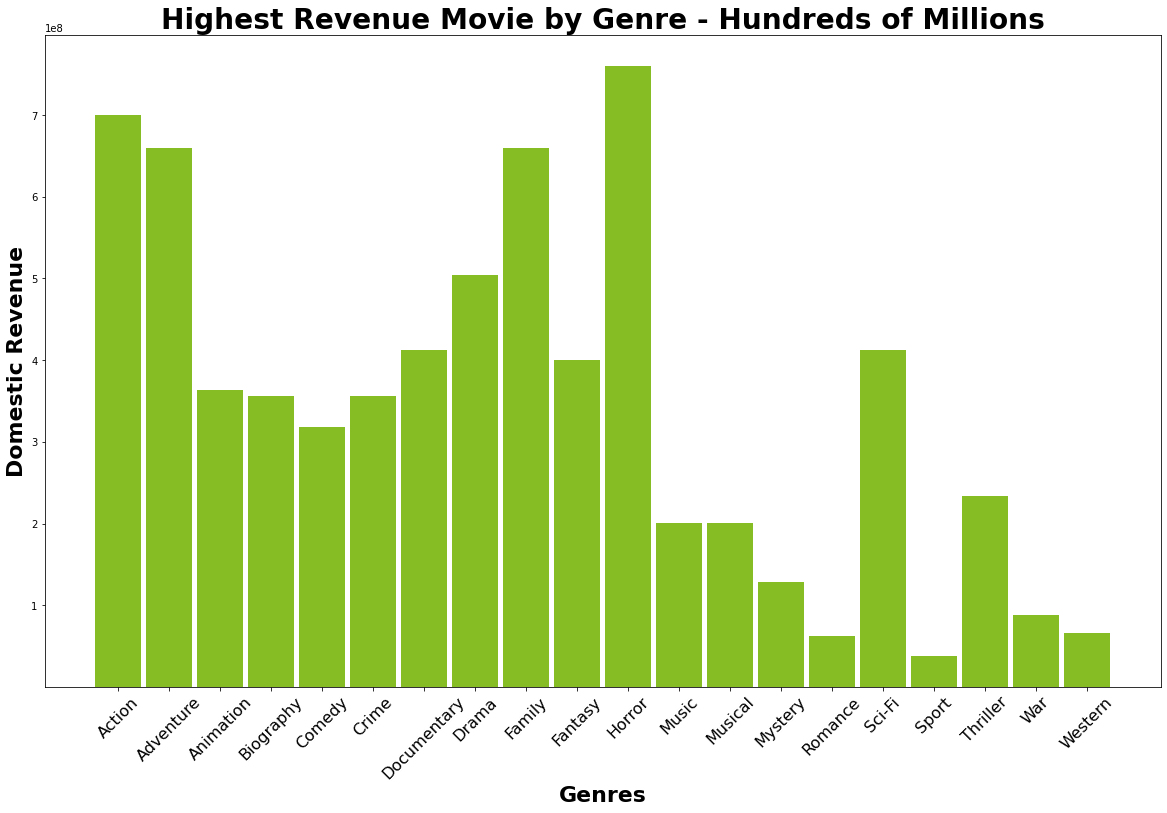

In [66]:
# plot genre in relation to revenue - this visualization excludes outliers

plt.figure(figsize=(20,12))

plt.bar(sorted_movies_df['main_genre'], sorted_movies_df["domestic_gross"], width=0.9, bottom=0.2, color='#86BC24')

plt.xlabel('Genres', fontsize=22, fontweight='bold')
plt.ylabel('Domestic Revenue', fontsize = 22, fontweight='bold')
plt.xticks(rotation='45', fontsize = 16)


plt.title('Highest Revenue Movie by Genre - Hundreds of Millions', fontsize = 28, fontweight='bold')


plt.show()


# Visualization Analysis: Bar Plot
According to our bar plot, the genres with the greatest performing movies in terms of gross domestic revenue are of the horror, action, family, and adventure genres. It is to be noted that often times action, family, and adventure movies are typically marketed towards and consumed by a wider group of people due to age appropriate ratings as opposed to horror, which is often times rated PG-13 or R and cannot be seen by a large group of people. This notion will guide our hypothesis test that is later to come.

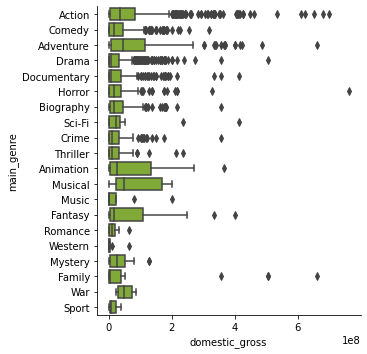

In [67]:
sns.catplot(data=movies_df, x="domestic_gross", y="main_genre", kind="box", color='#86BC24')

# Visualization Analysis: Box Plot
According to our boxplot, we can see several outliers beyond the cohorts exist in the action and adventure categories, meaning these genres have several movies that performed extremely well compared to other movies. Note that horror films have less outliers than the other genres as well as smaller measures of central tendency than animation, adventure, action, and musical genres. Let's see what those top grossing movies are called.

In [17]:
top_action = movies_df[(movies_df['main_genre'] == 'Action') & (movies_df['domestic_gross'] > 600000000)]
top_action

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,id,release_date,production_budget,domestic_gross,worldwide_gross,main_genre
12,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",34,"Jun 12, 2015","$215,000,000",652270625,"$1,648,854,864",Action
141,tt0848228,The Avengers,The Avengers,2012,143.0,"Action,Adventure,Sci-Fi",27,"May 4, 2012","$225,000,000",623279547,"$1,517,935,897",Action
1835,tt1825683,Black Panther,Black Panther,2018,134.0,"Action,Adventure,Sci-Fi",42,"Feb 16, 2018","$200,000,000",700059566,"$1,348,258,224",Action
3218,tt3606756,Incredibles 2,Incredibles 2,2018,118.0,"Action,Adventure,Animation",44,"Jun 15, 2018","$200,000,000",608581744,"$1,242,520,711",Action
3360,tt4154756,Avengers: Infinity War,Avengers: Infinity War,2018,149.0,"Action,Adventure,Sci-Fi",7,"Apr 27, 2018","$300,000,000",678815482,"$2,048,134,200",Action


### Superheroes
All but one of our top 5 action movies are about superheroes, two were a part of the same saga, Avengers, and two of them are sequels to very successful movies. This says a lot about the cinema audience. What about our greatest value, the horror film as shown in the box plot?

In [18]:
top_horror = movies_df[(movies_df['main_genre'] == 'Horror') & (movies_df['domestic_gross'] > 600000000)]
top_horror

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,id,release_date,production_budget,domestic_gross,worldwide_gross,main_genre
1747,tt1775309,Avatar,Abatâ,2011,93.0,Horror,1,"Dec 18, 2009","$425,000,000",760507625,"$2,776,345,279",Horror


The top grossing movie of this entire dataset is Avatar at over $2.7 billion! Classified as a horror movie in our dataset, it is considered to be a dystopian action movie. 

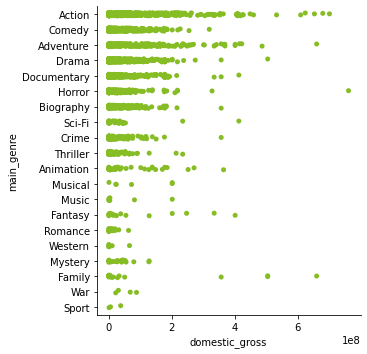

In [68]:
cp = sns.catplot(data=movies_df, x="domestic_gross", y="main_genre", color='#86BC24')

# Visualization Analysis: Categorical Plot
Our categorical plot differs from the previous two graphs, depicting action as the most successful movie genre in terms of gross domestic revenue, followed by adventure, and the horror genre looks like it pulls in much less.


# Hypothesis Test: Best Movie Genre?
We hypothesize that the movies which are classified as action have a higher gross revenue than other genres as it is typically a more family-friendly genre. 

## Null: Action movies have a lower or equal average gross domestic revenue than the rest of movies 


## Alternative: Action movies have a significantly greater gross domestic revenue than the rest of movies

We will be conducting a one sample z-test at the alpha level of 0.05 to compare the mean gross revenue of action movies versus the mean gross revenue of all movies, to see if this genre sticks out as more successful than others. 

In [42]:
a = 0.05
a

0.05

In [27]:
mu = movies_df['domestic_gross'].mean() # population mean
mu

40874293.98954507

In [28]:
sigma = movies_df['domestic_gross'].std() # population standard deviation
sigma

71722959.89199439

In [29]:
n = len(movies_df[movies_df['main_genre'] == 'Action']) # sample size
n

667

In [30]:
# query domestic gross for just action movies and store it into variable to calculate 'sample' mean
sample_action = movies_df.query("main_genre == 'Action'")['domestic_gross']
sample_action

0               0
1        70433227
11       26017685
12      652270625
18       73058679
          ...    
3760     30376755
3763            0
3778     55591409
3802     57806952
3812     23530831
Name: domestic_gross, Length: 667, dtype: int32

In [25]:
x_bar = sample_action.mean() # sample mean
x_bar

67877437.011994

In [33]:
# calculcate the test statistic
z = (x_bar - mu)/(sigma/sqrt(n))
z

9.723419649917899

In [40]:
# calculate the p-value
p = 1 - stats.norm.cdf(z)
p

0.0

In [43]:
# interpret our p-value in terms of our alpha level 
# Is there is a statistically significant difference?
# Can we reject the null hypothesis?
p < a

True

Our p-value is less than the alpha so we must reject the null hypothesis!

## Hypothesis Test Results 
### We reject the null and conclude that action movies have a significantly greater gross domestic revenue than the rest of movies!

Taking this into consideration, we make the suggestion that the studio should focus on creating action movies in order to maximize revenue.

<img src="https://assets.simpleviewinc.com/simpleview/image/upload/c_fill,h_805,q_50,w_1903/v1/clients/eauclaire-redesign/2da0fb8c_23a4_430a_b852_abb92a27f8b0_1d053ad0-78ed-4dc2-8fb2-47f6160893e8.jpg" width=500>

Image Source: https://www.visiteauclaire.com/things-to-do/arts/cinemas/

*This notebook was created by Skylar Miller and Ellis Hartley*


# Backround 

We think that the summer months will perform the best because students are out of school and families will be looking for ways to entertain their children. School is out in the US during June, July, and most of December. With heat waves in full effect, we think the summer months will perform the best.  

**Our question:** Are gross revenue sales from summer months greater than that of other seasons as a whole?

# Assumptions

- We're only interested in domestic gross revenue to keep seasonality consistent. According to [gizmodo](https://gizmodo.com/how-much-money-does-a-movie-need-to-make-to-be-profitab-5747305), "generally, domestic revenue seems to be better for studios than overseas revenue, because the studios take a bigger cut of domestic revenue."

# Hypothesis

**Null Hypothesis:** Summer month revenue is less than or equal to other month revenues. 
 
**Alternative Hypothesis:** Summer month revenue is greater than other month revenues.

# Data Exploration

After previewing (see below) the available data sources, we decided to go with The Numbers Dataset because it contains the release dates and gross revenue of each movie. More info on this dataset can be found here: https://www.the-numbers.com/

In [1]:
# importing the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from scipy.stats import stats
import datetime as datetime

In [2]:
# Box office movies dataset

df_bom = pd.read_csv('../../zippedData/bom.movie_gross.csv.gz')
df_bom.head(1)

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010


In [3]:
# TheMovieDB dataset

df_tmbd = pd.read_csv('../../zippedData/tmdb.movies.csv.gz')
df_tmbd.head(1)

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788


In [4]:
# The Numbers dataset

df_tn = pd.read_csv('../../zippedData/tn.movie_budgets.csv.gz')
df_tn.head(1)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"


In [5]:
# Rotten Tomatoes movie info dataset

df_rt_info = pd.read_csv('../../zippedData/rt.movie_info.tsv.gz', sep='\t')
df_rt_info.head(1)

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN


In [6]:
# Rotten Tomatoes movie reviews dataset

df_rt_reviews = pd.read_csv('../../zippedData/rt.reviews.tsv.gz', sep='\t', encoding='ansi')
df_rt_reviews.head(1)

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"


# Our analysis starts here
------------------------------------------------------------------------------------
### Data exploration

As shown below, this dataset consists of 5782 rows with no Null values. However, our sales and budget columns are categorized as text. We will need to convert these columns to integers. 

In [7]:
df_tn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [8]:
# This function takes in a string, removes the dollar sign and commas, 
# and returns an integer (ex: $1,000 --> 1000) 

def clean_dollar(df, column):
    df[column] = df[column].str.strip('$')
    df[column] = df[column].str.replace(',','')
    df[column] = df[column].astype('int64')
    return df[column]

clean_dollar(df_tn,'production_budget') 
clean_dollar(df_tn,'domestic_gross')
clean_dollar(df_tn,'worldwide_gross')

0       2776345279
1       1045663875
2        149762350
3       1403013963
4       1316721747
           ...    
5777             0
5778        240495
5779          1338
5780             0
5781        181041
Name: worldwide_gross, Length: 5782, dtype: int64

In [9]:
df_tn.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,425000000,760507625,2776345279
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,"Jun 7, 2019",Dark Phoenix,350000000,42762350,149762350
3,4,"May 1, 2015",Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747


#### Now that our gross sales and budget are integers, we can take a quick look at some of our data statistics.

In [10]:
df_tn.describe()

,id,production_budget,domestic_gross,worldwide_gross
count,5782.000000,5.782000e+03,5.782000e+03,5.782000e+03
mean,50.372363,3.158776e+07,4.187333e+07,9.148746e+07
std,28.821076,4.181208e+07,6.824060e+07,1.747200e+08
min,1.000000,1.100000e+03,0.000000e+00,0.000000e+00
25%,25.000000,5.000000e+06,1.429534e+06,4.125415e+06
50%,50.000000,1.700000e+07,1.722594e+07,2.798445e+07
75%,75.000000,4.000000e+07,5.234866e+07,9.764584e+07
max,100.000000,4.250000e+08,9.366622e+08,2.776345e+09


### Further exploring issues in the dataset

After sorting our dataset, it looks like there are a lot of movies with 0 domestic gross revenue. Below, we explore these issues with revenue further. 

In [11]:
# sorting by domestic gross in ascending order

df_tn.sort_values(by=['domestic_gross'], ascending=True).head(10)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
3231,32,"Dec 31, 2008",Ca$h,13700000,0,11738256
4762,63,"Dec 31, 2009",Chicago Overcoat,3000000,0,0
4763,64,"Sep 13, 2011",Never Back Down 2: The Beatdown,3000000,0,0
4764,65,"Dec 31, 2015",AWOL-72,3000000,0,0
4194,95,"May 10, 2011",The Hit List,6000000,0,0
4765,66,"Jan 15, 2013",30 Nights Of Paranormal Activity With The Devi...,3000000,0,0
4766,67,"Feb 6, 2015",Enter the Dangerous Mind,3000000,0,0
5207,8,"Dec 31, 2013",The Vatican Exorcisms,1100000,0,0
5206,7,"Dec 31, 2010",The Dead Undead,1100000,0,0
5205,6,"Apr 7, 2015",Silent Running,1100000,0,0


Below we see there are 548 rows of data where domestic gross revenue is equal to 0.

In [12]:
df_zeros = df_tn[df_tn['domestic_gross']==0]
print(len(df_zeros))
df_zeros

548


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
194,95,"Dec 31, 2020",Moonfall,150000000,0,0
479,80,"Dec 13, 2017",Bright,90000000,0,0
480,81,"Dec 31, 2019",Army of the Dead,90000000,0,0
535,36,"Feb 21, 2020",Call of the Wild,82000000,0,0
617,18,"Dec 31, 2012",AstÃ©rix et ObÃ©lix: Au service de Sa MajestÃ©,77600000,0,60680125
...,...,...,...,...,...,...
5761,62,"Dec 31, 2014",Stories of Our Lives,15000,0,0
5764,65,"Dec 31, 2007",Tin Can Man,12000,0,0
5771,72,"May 19, 2015",Family Motocross,10000,0,0
5777,78,"Dec 31, 2018",Red 11,7000,0,0


Something else is going on here since these revenues are too low. A quick google search on "Ed and his Dead Mother" shows a few well-known actors so these numbers are probably incorrect. Again, this shouldn't be an issue if we filter out all below average revenue movies.

In [13]:
# dropping rows where domestic gross is zero

df = df_tn.drop(df_tn[df_tn['domestic_gross']==0].index)

df.sort_values(by=['domestic_gross'], ascending=True).head(10)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
3731,32,"Dec 26, 2014",Barbecue,10000000,388,247565
5770,71,"Aug 14, 2008",The Rise and Fall of Miss Thang,10000,401,401
5518,19,"Oct 13, 2005",The Dark Hours,400000,423,423
5769,70,"Apr 1, 1996",Bang,10000,527,527
5466,67,"May 11, 2018",Higher Power,500000,528,528
5027,28,"Jan 1, 1993",Ed and his Dead Mother,1800000,673,673
5298,99,"Dec 13, 2002",The Jimmy Show,1000000,703,703
4422,23,"Oct 19, 2007",Out of the Blue,4600000,728,731767
4081,82,"May 21, 2010",Perrierâs Bounty,6600000,828,828
5297,98,"Apr 21, 2006",In Her Line of Fire,1000000,884,884


### Filtering our data for above average revenue and 2010 and up

Since we are only interested in successful movies, we are going to filter our dataset to only include "above average" movies. Also, since the movie industry has changed over the years, we are only going to include movies that were created during or after 2010. 

In [14]:
average_dom_gross = df['domestic_gross'].mean()
print(average_dom_gross)
cutoff_year = 2010

46257465.79002675


In [15]:
# converting date column to datetime

df['release_date'] = pd.to_datetime(df['release_date'])
df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,425000000,760507625,2776345279
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747
...,...,...,...,...,...,...
5775,76,2006-05-26,Cavite,7000,70071,71644
5776,77,2004-12-31,The Mongol King,7000,900,900
5778,79,1999-04-02,Following,6000,48482,240495
5779,80,2005-07-13,Return to the Land of Wonders,5000,1338,1338


In [16]:
df_filtered = df[(df['domestic_gross'] > average_dom_gross) & (df['release_date'].dt.year >= cutoff_year)]
df_filtered

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747
5,6,2015-12-18,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220
6,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200
...,...,...,...,...,...,...
4666,67,2013-06-07,The Purge,3000000,64473115,91266581
4668,69,2012-10-12,Sinister,3000000,48086903,87727807
5062,63,2011-04-01,Insidious,1500000,54009150,99870886
5189,90,2014-03-21,Godâs Not Dead,1150000,60755732,63777092


We have 614 movies in our dataset. At this point, we are ready for our analysis.

# Data Analysis

In this section, we plot out the following:

- Count of movies by season
- Total revenue by season
- Average revenue by season

### Creating the 'seasons' column 

In [17]:
# Create a new row called 'seasons' that categorizes the dates columns by season. Seasons are as follows:

# summer = june 21 - sept 22 (06/21-09/22) --> summer months = 6,7,8
# fall = sept 23 - dec 20 (09/23-12/20) --> fall months = 9,10,11
# winter = dec 21 - mar 18 (12/21-03/18) --> winter months = 12,1,2
# spring = mar 19 - jun 20 (03/19-06/20) --> spring months = 3,4,5

summer = [6, 7, 8]
fall = [9, 10, 11]
winter = [12, 1, 2]
spring = [3, 4, 5]

def f(row):
    if row['release_date'].month in summer:
        val = 'Summer'
    elif row['release_date'].month in fall:
        val = 'Fall'
    elif row['release_date'].month in winter:
        val = 'Winter'
    else:
        val = 'Spring'
    return val

df_filtered['seasons'] = df_filtered.apply(f, axis=1)

<ipython-input-17-7708eb4f38b1>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['seasons'] = df_filtered.apply(f, axis=1)


In [18]:
df_filtered.head(10)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,seasons
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,Spring
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,Spring
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,Winter
5,6,2015-12-18,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,Winter
6,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,Spring
8,9,2017-11-17,Justice League,300000000,229024295,655945209,Fall
9,10,2015-11-06,Spectre,300000000,200074175,879620923,Fall
10,11,2012-07-20,The Dark Knight Rises,275000000,448139099,1084439099,Summer
11,12,2018-05-25,Solo: A Star Wars Story,275000000,213767512,393151347,Spring
12,13,2013-07-02,The Lone Ranger,275000000,89302115,260002115,Summer


In [19]:
df_filtered.describe()

,id,production_budget,domestic_gross,worldwide_gross
count,614.000000,6.140000e+02,6.140000e+02,6.140000e+02
mean,51.540717,8.632467e+07,1.322118e+08,3.341941e+08
std,28.374634,6.774915e+07,1.072979e+08,3.035360e+08
min,1.000000,1.000000e+06,4.629074e+07,4.787957e+07
25%,28.000000,3.200000e+07,6.371371e+07,1.331047e+08
50%,52.000000,6.500000e+07,9.352667e+07,2.204450e+08
75%,75.750000,1.300000e+08,1.610963e+08,4.111946e+08
max,100.000000,4.106000e+08,9.366622e+08,2.053311e+09


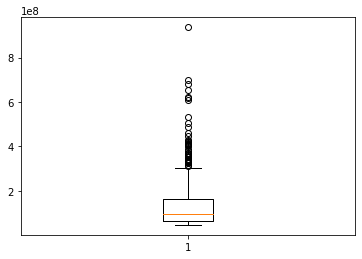

In [20]:
# a boxplot of our domestic gross column

plt.boxplot(df_filtered['domestic_gross'])
plt.show()

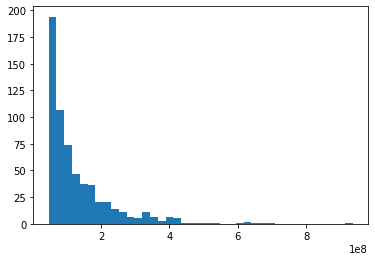

In [21]:
# a histogram of our domestic gross column

plt.hist(df_filtered['domestic_gross'], bins='auto')
plt.show()

In [22]:
df_filtered['domestic_gross'].median()

93526665.5

This is a non-normal distribution that is highly skewed. 

<AxesSubplot:xlabel='seasons'>

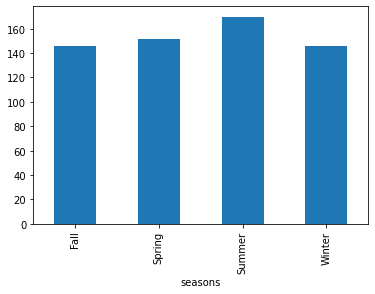

In [23]:
# plotting count of movies by season
   
df_filtered.groupby('seasons')['movie'].count().plot(kind='bar')

<AxesSubplot:xlabel='seasons'>

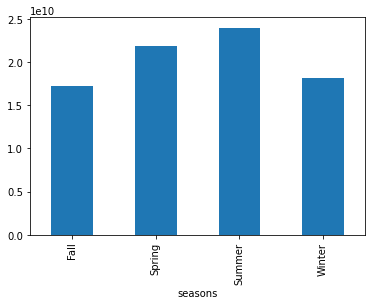

In [24]:
# plotting sum of gross revenue generated from movies by season

df_filtered.groupby('seasons')['domestic_gross'].sum().plot(kind='bar')

In [25]:
df_means = df_filtered.groupby('seasons')['domestic_gross'].mean().reset_index()
df_means

,seasons,domestic_gross
0,Fall,1.178734e+08
1,Spring,1.434735e+08
2,Summer,1.410806e+08
3,Winter,1.244989e+08


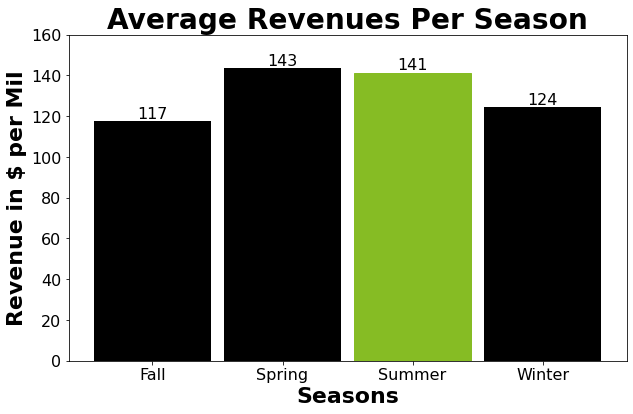

In [26]:
# plotting average of gross revenue generated from movies by season
seasons = df_means['seasons']
rev_per_mil = df_means['domestic_gross']/1000000

# sns.set_style('dark')

plt.figure(figsize=(10,6))

barlist = plt.bar(seasons, rev_per_mil, width=0.9, color = 'black')
barlist[2].set_color('#86BC24')
plt.title('Average Revenues Per Season', fontsize=28, fontweight='bold')
plt.xlabel("Seasons", fontsize=22, fontweight='bold')
plt.ylabel("Revenue in $ per Mil", fontsize=22, fontweight='bold')
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylim(top=160)


for index, value in enumerate(rev_per_mil.astype(int)):
    plt.text(index,value+2, str(value), fontsize=16, horizontalalignment='center')

plt.show()    


Our plot seems to somewhat agree with our hypothesis. If we wanted to further test our hypothesis, we could perform a chi-squared test, as shown below. 


In [27]:
summer_df = df_filtered[df_filtered['seasons']=='Summer']
print(f"mean: {summer_df['domestic_gross'].mean().astype(int)}; number of movies: {len(summer_df)}")

mean: 141080559; number of movies: 170


In [28]:
summer_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,seasons
10,11,2012-07-20,The Dark Knight Rises,275000000,448139099,1084439099,Summer
12,13,2013-07-02,The Lone Ranger,275000000,89302115,260002115,Summer
28,29,2013-06-14,Man of Steel,225000000,291045518,667999518,Summer
30,31,2012-07-03,The Amazing Spider-Man,220000000,262030663,757890267,Summer
32,33,2017-06-21,Transformers: The Last Knight,217000000,130168683,602893340,Summer


In [29]:
import scipy.stats as stats
from math import sqrt
import numpy as np
from numbers import Number

# Population mean
mu_0 = df_filtered['domestic_gross'].mean()

# Population standard deviation
sigma = df_filtered['domestic_gross'].std()

# Mean gross revenue of summer sample
x_bar = summer_df['domestic_gross'].mean()

# std gross revenue of summer sample
x_std = summer_df['domestic_gross'].std()

# Number of movies in the whole population
n = len(df_filtered)

# Number of movies in the sample
n_sample = len(summer_df)

# Alpha (1 - confidence level)
alpha = 0.05

### Further analysis based on months and comparing gross revenue to net revenue
We wanted to drill down on our data and break revenue down by the month to see what month would be the most optimal to release a movie.  

In [30]:
df_filtered['month_name'] = df_filtered['release_date'].dt.strftime('%b')
df_filtered['month'] = df_filtered['release_date'].dt.month

df_filtered

<ipython-input-30-b0d64b85b55c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['month_name'] = df_filtered['release_date'].dt.strftime('%b')
<ipython-input-30-b0d64b85b55c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['month'] = df_filtered['release_date'].dt.month


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,seasons,month_name,month
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,Spring,May,5
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,Spring,May,5
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,Winter,Dec,12
5,6,2015-12-18,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,Winter,Dec,12
6,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,Spring,Apr,4
...,...,...,...,...,...,...,...,...,...
4666,67,2013-06-07,The Purge,3000000,64473115,91266581,Summer,Jun,6
4668,69,2012-10-12,Sinister,3000000,48086903,87727807,Fall,Oct,10
5062,63,2011-04-01,Insidious,1500000,54009150,99870886,Spring,Apr,4
5189,90,2014-03-21,Godâs Not Dead,1150000,60755732,63777092,Spring,Mar,3


In [31]:
df_filtered['net_revenue'] = df_filtered['worldwide_gross'].astype(int) - df_filtered['production_budget']
df_filtered

<ipython-input-31-7f45004f86ed>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['net_revenue'] = df_filtered['worldwide_gross'].astype(int) - df_filtered['production_budget']


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,seasons,month_name,month,net_revenue
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,Spring,May,5,635063875
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,Spring,May,5,1072413963
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,Winter,Dec,12,999721747
5,6,2015-12-18,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220,Winter,Dec,12,1747311220
6,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200,Spring,Apr,4,1748134200
...,...,...,...,...,...,...,...,...,...,...
4666,67,2013-06-07,The Purge,3000000,64473115,91266581,Summer,Jun,6,88266581
4668,69,2012-10-12,Sinister,3000000,48086903,87727807,Fall,Oct,10,84727807
5062,63,2011-04-01,Insidious,1500000,54009150,99870886,Spring,Apr,4,98370886
5189,90,2014-03-21,Godâs Not Dead,1150000,60755732,63777092,Spring,Mar,3,62627092


<AxesSubplot:xlabel='month'>

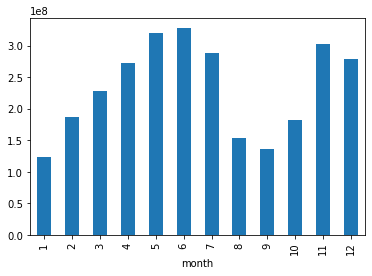

In [32]:
df_filtered.groupby('month')['net_revenue'].mean().plot(kind='bar')

In [33]:
# you need to type this in
month = ['Jan', 'Feb', 'Mar', 'Apr',
          'May', 'Jun', 'Jul', 'Aug',
          'Sep', 'Oct', 'Nov', 'Dec']

# (df.groupby(df['date'].dt.strftime('%B'))
#    ['total'].sum()
#    .reindex(months)
#    .plot.bar(figsize=(20,10))
# )


month_means = df_filtered.groupby('month')['domestic_gross'].mean().reset_index()

months = month_means['month']
rev_per_mth = month_means['domestic_gross']/1000000
months

0      1
1      2
2      3
3      4
4      5
5      6
6      7
7      8
8      9
9     10
10    11
11    12
Name: month, dtype: int64

In [34]:
df_filtered.groupby('month')['domestic_gross'].mean().reset_index()['domestic_gross']/1000000

0      76.323934
1     111.703293
2     134.172853
3     125.123016
4     164.320226
5     168.239166
6     139.881768
7     102.197922
8      83.710255
9      98.098265
10    149.565381
11    154.264547
Name: domestic_gross, dtype: float64

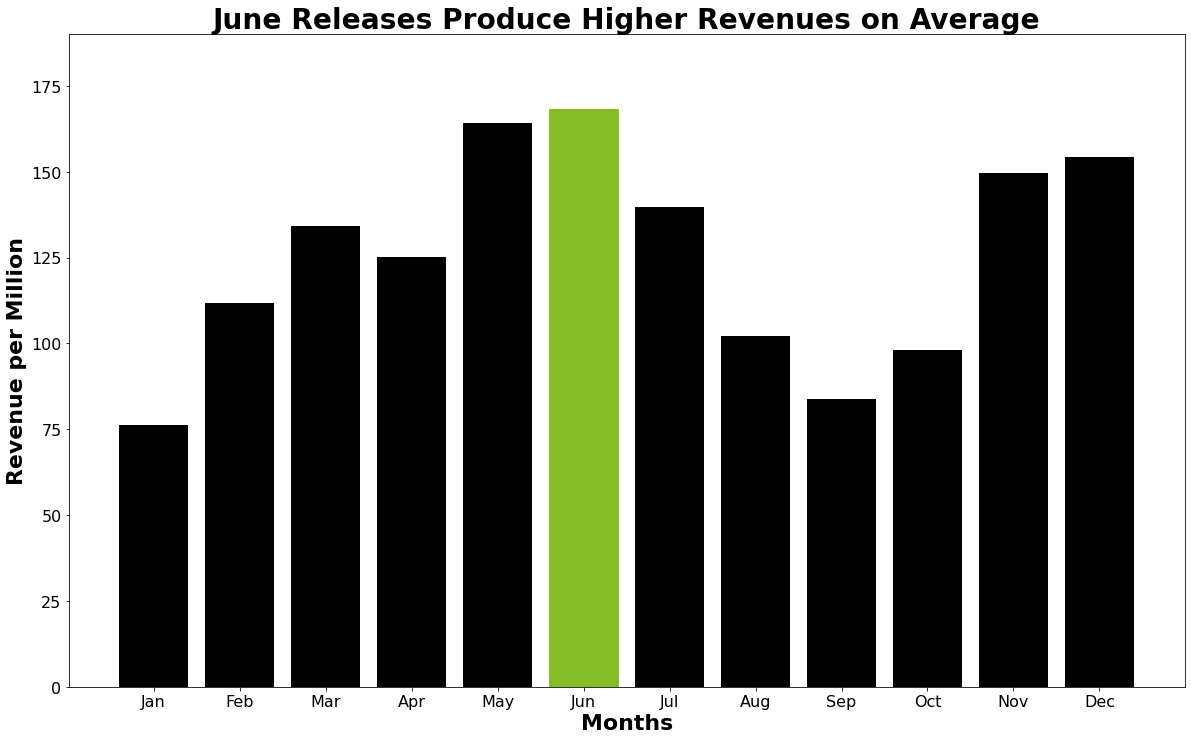

In [35]:
plt.figure(figsize=(20,12))

barlist = plt.bar(months, rev_per_mth, color = 'black')
barlist[5].set_color('#86BC24')
plt.title('June Releases Produce Higher Revenues on Average', fontsize=28, fontweight='bold')
plt.xlabel("Months", fontsize=22, fontweight='bold')
plt.ylabel("Revenue per Million", fontsize=22, fontweight='bold')
plt.xticks(ticks=months,labels=month,fontsize = 16)
plt.yticks(fontsize = 16)
plt.ylim(top=190)


# for index, value in enumerate(rev_per_mth.astype(int)):
#     plt.text(index,value, str(value), fontsize=16)

plt.show()    

# Length of Movie in Relation to Movie Earnings

### Importing the libraries and data provided to start visualizing and previewing the data that will be used in the analysis.

In [2]:
#Importing libraries that will be used
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import sqlite3

In [3]:
#Importing movie budgets and previewing data
df_gross = pd.read_csv('../../zippedData/tn.movie_budgets.csv.gz')
df_gross.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


### Taking a preview of the data that was imported so we can search for any missing values. This data will be joined with the SQL database im.db later so we can run queries more accurately.

In [4]:
#looking for missing data, rows and column information
df_gross.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


### Now that we saw a preview of the data, we needed to create a function which would help clean the domestic_gross column in our dataset in order to be used for statistical calculations later.

In [5]:
#Changing the domestic_gross values to an integer and removing $ and commas using a function
def clean_dollar(df, column):
    df[column] = df[column].str.strip('$')
    df[column] = df[column].str.replace(',','')
    df[column] = df[column].astype(int)
    return df[column]

In [6]:
#Applying function to columns and previewing data
clean_dollar(df_gross,'domestic_gross')
df_gross.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000",760507625,"$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000",241063875,"$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000",42762350,"$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000",459005868,"$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000",620181382,"$1,316,721,747"


# Slicing out columns that will be used for our analysis.

In [7]:
#Only selecting movie, and domestic_gross columns 
gross = df_gross.iloc[:, [2, 4]]
gross

,movie,domestic_gross
0,Avatar,760507625
1,Pirates of the Caribbean: On Stranger Tides,241063875
2,Dark Phoenix,42762350
3,Avengers: Age of Ultron,459005868
4,Star Wars Ep. VIII: The Last Jedi,620181382
...,...,...
5777,Red 11,0
5778,Following,48482
5779,Return to the Land of Wonders,1338
5780,A Plague So Pleasant,0


We decided to find the average domestic gross to verify what is considered above average and a successful movie. 

In [8]:
#Finding the mean/avg of the gross revenue
avgg = gross['domestic_gross'].mean()
avgg

41873326.867001034

# Importing SQL Database

In [9]:
#connecting to the sql database to import runtime minutes
con = sqlite3.connect('../../zippedData/im.db')
#Assigning a variable to sql query for runtime minutes
runtime = pd.read_sql("""
SELECT *
FROM movie_basics
""", con)
runtime.info() #Checking for null values and discrepancies

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146144 entries, 0 to 146143
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   movie_id         146144 non-null  object 
 1   primary_title    146144 non-null  object 
 2   original_title   146123 non-null  object 
 3   start_year       146144 non-null  int64  
 4   runtime_minutes  114405 non-null  float64
 5   genres           140736 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 6.7+ MB


### Ran a query to see that only 132 out of 114K movies were over 300 minutes long. Justifying the filter for 300 minutes.

In [10]:
runtime = pd.read_sql("""
SELECT COUNT(runtime_minutes) as high_run
FROM movie_basics
WHERE runtime_minutes is not null and runtime_minutes >= 300
order by runtime_minutes desc
""", con)
runtime

,high_run
0,132


In [11]:
#Updating runtime to only show runtimes under 5 hours
runtime = pd.read_sql("""
SELECT runtime_minutes
FROM movie_basics
WHERE runtime_minutes is not null AND runtime_minutes < 300
""", con)
run = runtime.astype(int) #Changing runtimes to integers
run.describe() #Getting statistical data on runtimes to determine avg movie length

,runtime_minutes
count,114273.000000
mean,84.737663
std,28.152987
min,1.000000
25%,70.000000
50%,87.000000
75%,99.000000
max,296.000000


In [12]:
#Importing movie_gross data into sql database for querying
gross.to_sql("movie_gross", con, if_exists="replace")

## Join together new movie_gross table with movie_basics to run a query and compare movie earnings with runtimes

In [13]:
filtered_gross = pd.read_sql("""
SELECT DISTINCT domestic_gross, runtime_minutes
FROM movie_gross
LEFT JOIN movie_basics
ON movie_gross.movie = movie_basics.primary_title
WHERE runtime_minutes is not null and runtime_minutes BETWEEN 30 AND 300 AND domestic_gross > 41873326
ORDER BY domestic_gross DESC
LIMIT 1000
""", con).drop_duplicates()
filtered_gross = filtered_gross.astype(int)
filtered_gross
#filtering out movies that made less than the average gross of 40 million and had runtimes between 30 minutes and 5 hours
#only showing movies that earned above the average domestic gross of 41873326

,domestic_gross,runtime_minutes
0,760507625,93
1,700059566,134
2,678815482,149
3,659363944,115
4,652270625,124
...,...,...
926,42340598,119
927,42073277,95
928,42065185,111
929,42025135,119


# Visualizations for the Analysis

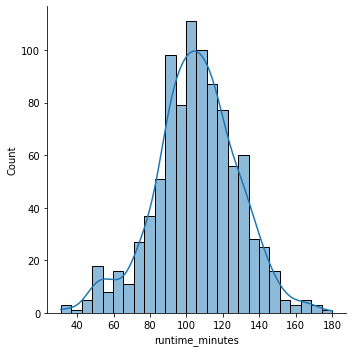

In [14]:
#Histogram showing runtime minutes for movies that earned above average revenue
sns.displot(filtered_gross['runtime_minutes'], bins='auto', kde=True)

Text(0.5, 1.0, 'Movie Earnings in Relation to Movie Runtime')

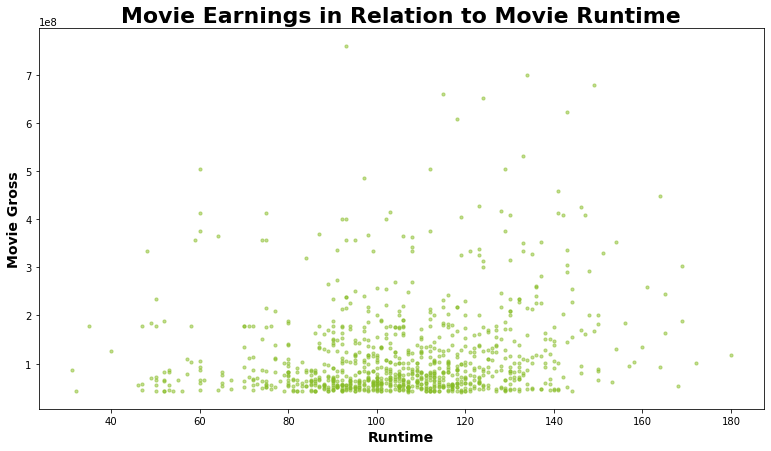

In [43]:
#Scatter plot visualization comparing revenue to movie length
filtered_gross.plot.scatter(x = 'runtime_minutes',y= 'domestic_gross',s = 10, c = '#86BC24', figsize=(13,7), alpha = 0.5)
plt.xlabel('Runtime', fontsize = 14, fontweight = 'bold')
plt.ylabel('Movie Gross', fontsize = 14, fontweight = 'bold')
plt.title('Movie Earnings in Relation to Movie Runtime', fontsize = 22, fontweight = 'bold')

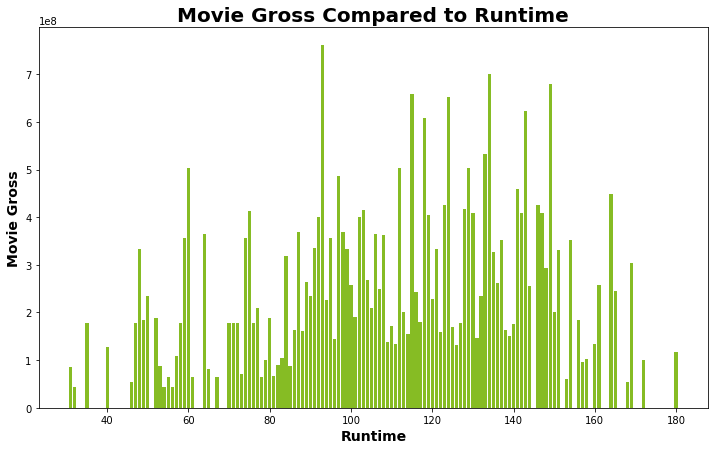

In [16]:
#
plt.figure(figsize=(12, 7))

plt.bar(filtered_gross['runtime_minutes'], filtered_gross['domestic_gross'], color = '#86BC24', edgecolor = 'none')
plt.title('Movie Gross Compared to Runtime', fontsize = 20, fontweight = 'bold')
plt.xlabel('Runtime', fontweight= 'bold', fontsize = 14)
plt.ylabel('Movie Gross', fontweight = 'bold', fontsize = 14)
plt.show()

In [55]:
minutes = [30, 60, 90, 120, 150, 180]
bin1 = range(30, 60)
bin2 = range(61, 90)
bin3 = range(91, 120)
bin4 = range(121, 150)
def f(row):
    if row['runtime_minutes'] in bin1:
        val = 'A'
    elif row['runtime_minutes'] in bin2:
        val = 'B'
    elif row['runtime_minutes'] in bin3:
        val = 'C'
    elif row['runtime_minutes'] in bin4:
        val = 'D'
    else:
        val = 'E'
    return val
filtered_gross['runtime_minutes_grouped'] = filtered_gross.apply(f, axis=1)
filtered_gross.head(25)

,domestic_gross,runtime_minutes,runtime_minutes_grouped,runtime_bin
0,760507625,93,C,91-120 Min
1,700059566,134,D,121-150 Min
2,678815482,149,D,121-150 Min
3,659363944,115,C,91-120 Min
4,652270625,124,D,121-150 Min
5,623279547,143,D,121-150 Min
6,608581744,118,C,91-120 Min
7,532177324,133,D,121-150 Min
8,504014165,112,C,91-120 Min
9,504014165,129,D,121-150 Min


In [56]:
df_run = filtered_gross.groupby('runtime_minutes_grouped')['domestic_gross'].mean().reset_index()
df_run

,runtime_minutes_grouped,domestic_gross
0,A,1.067598e+08
1,B,9.630135e+07
2,C,1.072987e+08
3,D,1.559560e+08
4,E,1.362772e+08


In [57]:
df_ordered = df_run.sort_values(['runtime_minutes_grouped','domestic_gross'], ascending=True)
df_ordered

,runtime_minutes_grouped,domestic_gross
0,A,1.067598e+08
1,B,9.630135e+07
2,C,1.072987e+08
3,D,1.559560e+08
4,E,1.362772e+08


# Visualization Chart Analysis
We created a bar chart to help show the movie runtimes in comparison to the domestic gross for each movie in 30 minute increments to help show the relationship.

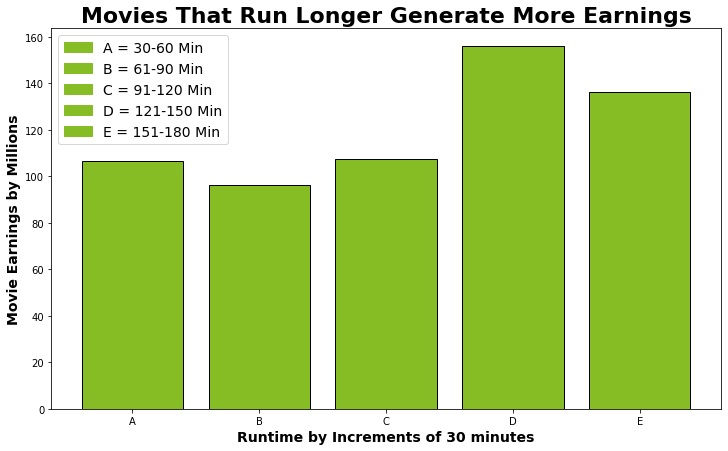

In [59]:
import matplotlib.patches as mpatches
plt.figure(figsize = (12, 7)) #adjusting the figure size of the bar graph
#Plotting a bar chart and dividing the domestic gross column by 1 million to have the y axis increments clearly defined
plt.bar(df_ordered['runtime_minutes_grouped'],df_ordered['domestic_gross']/1000000,align='center', edgecolor='black', color = '#86BC24')
plt.title('Movies That Run Longer Generate More Earnings', fontsize = 22, fontweight = 'bold') #plotting the title
plt.ylabel('Movie Earnings by Millions', fontsize = '14', fontweight = 'bold') #plotting the y axis label
plt.xlabel('Runtime by Increments of 30 minutes', fontsize = '14', fontweight = 'bold') #plotting the x axis label


patch1 = mpatches.Patch(color = '#86BC24', label= 'A = 30-60 Min')
patch2 = mpatches.Patch(color = '#86BC24', label = 'B = 61-90 Min')
patch3 = mpatches.Patch(color = '#86BC24', label = 'C = 91-120 Min')
patch4 = mpatches.Patch(color = '#86BC24', label = 'D = 121-150 Min')
patch5 = mpatches.Patch(color = '#86BC24', label = 'E = 151-180 Min')
plt.legend(handles=[patch1, patch2, patch3, patch4, patch5], fontsize = 14)

Based off of the above analysis and visualizations, we suggest making movies between 121 and 150 minutes in length to maximize profits. Taking into account the top 990 grossing movies that are between 30 minutes and 300 minutes in length.